In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf

파싱

In [2]:
def parsing(path):#파싱을 진행하는 함수
    with open(path,'r',encoding='utf-8') as f:#파일을 읽어드리고 ['로그','로그',...] 이런식으로 로그를 구조화
        train=[]
        para=""
        while True:
            l = f.readline() #한줄씩 읽어 옵니다

            if not l:
                break #파일을 전부 읽으면 읽기를 중단합니다.

            if l != "\n":
                para +=l
            else:
                if para!='':
                    if para[:4]=='POST': #Method가 POST인 경우 예외적으로 바디까지 가져옵니다.
                        para+=f.readline()
                    train.append(para)
                    para=""
    return train

In [3]:
def dataset(path,mod='train'): #데이터셋을 생성합니다. 파싱한 데이터와 라벨을 생성합니다 
    x = parsing(f'{path}norm_{mod}.txt') # mod에 따라 train을 가져올지 test 데이터를 가져올지 결정됩니다.
    y = [0]*len(x) # 정상 라벨 0 을 정상 데이터 개수 만큼 생성
    x += parsing(f'{path}anomal_{mod}.txt')
    y += [1]*(len(x)-len(y)) # 비정상 라벨 1을 비정상 데이터 개수 만큼 생성
    return x, y

데이터 불러오기

In [4]:
train_x, train_y = dataset('./','train')
test_x, test_y =  dataset('./','test')
print(f"train_x : {len(train_x)}")
print(f"train_y : {len(train_y)}")

train_x : 49167
train_y : 49167


In [5]:
# 불러온 문자열들을 tokenizer를 이용해 키:값 쌍으로 바꿔준다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)
# 문자열을 값(index)로 바꿔준다.
train_x_index = tokenizer.texts_to_sequences(train_x)

In [6]:
# 단어 -> 인덱스 키, 값 쌍
word_to_index = tokenizer.word_index
cnt = 0;
for key, value in word_to_index.items():
  cnt += 1;
  print("key : ", key, ", value : ", value)
  if(cnt==10):
    break

key :  5 , value :  1
key :  0 , value :  2
key :  q , value :  3
key :  8 , value :  4
key :  accept , value :  5
key :  xml , value :  6
key :  cache , value :  7
key :  text , value :  8
key :  application , value :  9
key :  x , value :  10


In [7]:
rare_words = 0; # 등장 빈도수가 1회인 단어의 수
total_words = len(word_to_index); # 총 단어의 수
for key, value in tokenizer.word_counts.items():
  if(value<=1):
    rare_words += 1
print("전체 단어 수 : ", total_words)
print("등장 빈도수가 1회 이하인 단어의 수 : ", rare_words)

전체 단어 수 :  82923
등장 빈도수가 1회 이하인 단어의 수 :  54798


In [8]:
#1회 이하인 단어는 제거한다.
tokenizer = Tokenizer(num_words = total_words - rare_words + 1)
tokenizer.fit_on_texts(train_x)
train_x_index = tokenizer.texts_to_sequences(train_x)
word_to_index = tokenizer.word_index

In [9]:
# 한 http 정보의 최대 길이
max_length = max(len(i) for i in train_x_index)
print(max_length)

248


In [10]:
# 훈련 데이터의 크기
train_x_pad = pad_sequences(train_x_index, maxlen=max_length)
print(train_x_pad.shape)

(49167, 248)


In [11]:
# 단어 집합의 크기
vocab_size = len(word_to_index) + 1

In [32]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32 / 64로해봄 비슷..
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid')) # 활성 함수

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.Precision(name='precision')\
                                                                        , tf.keras.metrics.Recall(name='recall')])
train_y = np.array(train_y)
# 1%는 검증에 사용
history = model.fit(train_x_pad, train_y, epochs=7, batch_size=64, validation_split=0.01)

Epoch 1/7
761/761 [==============================] - 55s 70ms/step - loss: 0.2653 - acc: 0.8844 - precision: 0.8813 - recall: 0.8283 - val_loss: 0.1313 - val_acc: 0.9533 - val_precision: 1.0000 - val_recall: 0.9533
Epoch 2/7
761/761 [==============================] - 53s 70ms/step - loss: 0.0701 - acc: 0.9804 - precision: 0.9811 - recall: 0.9707 - val_loss: 0.1086 - val_acc: 0.9736 - val_precision: 1.0000 - val_recall: 0.9736
Epoch 3/7
761/761 [==============================] - 54s 71ms/step - loss: 0.0386 - acc: 0.9906 - precision: 0.9922 - recall: 0.9847 - val_loss: 0.0959 - val_acc: 0.9736 - val_precision: 1.0000 - val_recall: 0.9736
Epoch 4/7
761/761 [==============================] - 53s 70ms/step - loss: 0.0308 - acc: 0.9932 - precision: 0.9947 - recall: 0.9886 - val_loss: 0.0778 - val_acc: 0.9858 - val_precision: 1.0000 - val_recall: 0.9858
Epoch 5/7
761/761 [==============================] - 53s 70ms/step - loss: 0.0269 - acc: 0.9936 - precision: 0.9946 - recall: 0.9897 - val_l

실제 정확도 확인

In [33]:
test_x_index = tokenizer.texts_to_sequences(test_x)
test_x_pad = pad_sequences(test_x_index, maxlen = max_length)
test_y = np.array(test_y)
_loss, _acc, _precision, _recall = model.evaluate(test_x_pad, test_y)
print("\n 테스트셋 accuracy: %.4f" % _acc)
print("테스트셋 precision: %.4f" % _precision)
print("테스트셋 recall: %.4f" % _recall)
_f1_score = 2 * (_precision*_recall) / (_precision + _recall)
print("테스트셋 f1_score : ", _f1_score)

385/385 [==============================] - 6s 14ms/step - loss: 0.0412 - acc: 0.9908 - precision: 0.9954 - recall: 0.9823

 테스트셋 accuracy: 0.9908
테스트셋 precision: 0.9954
테스트셋 recall: 0.9823
테스트셋 f1_score :  0.9888350934716266


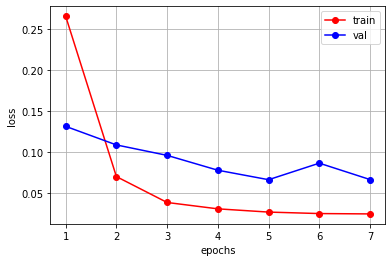

In [34]:
# 훈련, 검증 loss 그래프
epochs = range(1, 8)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(True)
plt.show()

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          2653568   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,655,681
Trainable params: 2,655,681
Non-trainable params: 0
_________________________________________________________________
